In [1]:
from keras.datasets import mnist
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pdb # for debug
 

Using TensorFlow backend.
/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1次元の畳み込みニューラルネットワークスクラッチ

**畳み込みニューラルネットワーク（CNN）** のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の **畳み込み層** を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

## 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

## データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$
 : 出力される配列のi番目の値


$F$
 : フィルタのサイズ


$x(_{i+s})$
 : 入力の配列の(i+s)番目の値


$w_s$
 : 重みの配列のs番目の値


$b$
 : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

$α$
  : 学習率


$\frac{\partial L}{\partial w_s}$: $w_s$
に関する損失 $L$の勾配

$\frac{\partial L}{\partial b}$
 : 
$b$
 に関する損失 
$L$
 の勾配


勾配 
$\frac{\partial L}{\partial w_s}$や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$


$\frac{\partial L}{\partial a_i}$
 : 勾配の配列のi番目の値


$N
_{o
u
t}$
 : 出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$


$\frac{\partial L}{\partial x_j}$
 : 前の層に流す誤差の配列のj番目の値


ただし、 
$j−s<0$
 または 
$j−s>N_{out}−1$
 のとき 
$\frac{\partial L}{\partial a_{(j-s)}} =0$
 です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。



In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

### 【問題1】解答

In [3]:
class SimpleConv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, W, B):
        self.W = W
        self.B = B
        self.lr = 1
               
    def forward(self, x):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.N_in = len(x) # 入力のサイズ（特徴量の数）
        self.P = 0 # Padding
        self.F = len(self.W) # フィルタのサイズ
        self.S = 1 # stride
        self.N_out = int((self.N_in + 2* self.P - self.F)/self.S + 1) # 𝑁𝑜𝑢𝑡  : 出力のサイズ（特徴量の数
        
        self.Z = x # 今回必要？
        self.A = np.empty(self.N_out)
        for i in range(self.F-1):
            self.A[i] = sum(x[i:i + self.F]*self.W)+self.B
        return self.A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dA = dA  # 今回必要？
                
        dZ = np.empty(self.N_in)
        for j in range(self.N_in):
            dZ_list = np.empty(self.F)
            for i in range(self.F):
                val = j - i
                if val < 0 or val > self.N_out -1:
                    dZ_list[i] = 0
                else:
                    dZ_list[i] = dA[val]*self.W[i]
                dZ[j] = sum(dZ_list) 
        self.dZ = dZ
        return dZ
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.X = X
        self.forward(X)
        dA = np.array([10, 20])
        self.backward(dA)
        # w 更新
        new_W = np.empty(self.F)
        for i in range(self.F):
            new_W[i] = sum(self.X[i:i+self.N_out]*dA)
        self.W = new_W
        # b 更新  
        new_B = sum(dA)
        self.B = new_B 
        
    def predict(self, X):
        """
        

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        self.forward_propagation_func(X)
        return np.argmax(self.z3, axis=1)

## 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

$N
_{o
u
t}$
 : 出力のサイズ（特徴量の数）


$N_{
i
n}$
 : 入力のサイズ（特徴量の数）


$P$
 : ある方向へのパディングの数


$F$
 : フィルタのサイズ


$S$
 : ストライドのサイズ

### 【問題2】解答

In [ ]:
# dA = np.array([10, 20]) # バックプロバゲーションここから始まる

# # w 更新
# w_new = np.empty(F)
# for i in range(F):
#     w_new[i] = sum(x[i:i+N_out]*dA)

# w_new
# # b 更新  
# b_new = sum(dA)




# # delta_b = np.array([30])
# # delta_w = np.array([50, 80, 110])
# # delta_x = np.array([30, 110, 170, 140])

In [ ]:
# N_in = len(x) # 入力のサイズ（特徴量の数）
# P = 0 # Padding
# F = len(w) # フィルタのサイズ
# S = 1 # stride
# N_out = int((N_in + 2* P - F)/S + 1)
# N_out # 𝑁𝑜𝑢𝑡  : 出力のサイズ（特徴量の数

In [ ]:
# # bk-proba
# dZ = np.empty(N_in)
# for j in range(N_in):
#     dZ_list = np.empty(F)
#     for i in range(F):
#         val = j - i
#         print(val)
#         if val < 0 or val > N_out -1:
#             dZ_list[i] = 0
#         else:
#             dZ_list[i] = dA[val]*w[i]
#         dZ[j] = sum(dZ_list)
# dZ

## 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力$x$、重み$w$、バイアス$b$を次のようにします。

In [5]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

フォワードプロパゲーションをすると出力は次のようになります。

In [6]:
a = np.array([35, 50])

a

array([35, 50])

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [7]:
delta_a = np.array([10, 20]) # バックプロバゲーションここから始まる

バックプロパゲーションをすると次のような値になります。



In [8]:
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])

### 【問題3】解答

In [10]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

sample = SimpleConv1d(w, b)
y = np.array([30, 110, 170, 140]) # fit用の仮値
sample.fit(x, y)
print('a:', sample.A)
print('delta_b:', sample.B)
print('delta_w:', sample.W)
print('delta_x:', sample.dZ)

a: [35. 50.]
delta_b: 30
delta_w: [ 50.  80. 110.]
delta_x: [ 30. 110. 170. 140.]


In [ ]:
# # fw-proba
# A = np.empty(N_out)
# for i in range(F-1):
#     A[i] = sum(x[i:i + F]*w)+b
# A

## 実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。



In [11]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
a+b

array([35., 50.])

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。


また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

In [12]:
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])


[[1 2 3]
 [2 3 4]]


このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。


畳み込みの計算方法に正解はないので、自分なりに効率化していってください。


**《参考》**


以下のページのInteger array indexingの部分がこの方法についての記述です。


[Indexing — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。


例えば以下のようなx, w, bがあった場合は、

In [14]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [15]:
np.sum(x[:,0:2], axis=0)
np.sum(x[:,0:3]*w[0,:,0:3])

15.0

出力は次のようになります。

In [16]:
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。


入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。


**《補足》**


チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(`バッチサイズ`、`チャンネル数`、`特徴量数`)または(`バッチサイズ`、`特徴量数`、`チャンネル数`)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）


今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(`チャンネル数`、`特徴量数`)です。

In [17]:
## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
## フォワードプロパゲーション・バックプロパゲーションの確認用トイデータ

import numpy as np

x_ = np.array([[1,2,3,4],
               [2,3,4,5]])


w_ = np.array([[[1,1,2],[2,1,1]],
              [[2,1,1],[1,1,1]],
              [[1,1,1],[1,1,1]]])


b_ = np.array([1,2,3])

# フォワードの出力
out_ = np.array([[21,29],
                [18,25],
                [18,24]])


loss_ = np.array([[9,11],
                [32,35],
                [52,56]])


# バックワードの勾配
x_delta = np.array([[125,230,204,113],
                    [102,206,195,102]])


w_delta = np.array([[[31,51,71],[51,71,91]],
                    [[102,169,236],[169,236,303]],
                    [[164,272,380],[272,380,488]]])


print('x_:　\n',x_)
print('x_shape:　\n',x_.shape)
print('---------')
print('w_:　\n',w_)
print('w_shape:　\n',w_.shape)
print('---------')
print('b_:　\n',b_)
print('b_shape:　\n',b_.shape)
print('---------')
print('out_:　\n',out_)
print('out_shape:　\n',out_.shape)
print('---------')
print('loss_:　\n',loss_)
print('loss_shape:　\n',loss_.shape)
print('---------')
print('x_delta:　\n',x_delta)
print('x_delta_shape:　\n',x_delta.shape)
print('---------')
print('w_delta:　\n',w_delta)
print('w_delta_shape:　\n',w_delta.shape)


x_:　
 [[1 2 3 4]
 [2 3 4 5]]
x_shape:　
 (2, 4)
---------
w_:　
 [[[1 1 2]
  [2 1 1]]

 [[2 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]]]
w_shape:　
 (3, 2, 3)
---------
b_:　
 [1 2 3]
b_shape:　
 (3,)
---------
out_:　
 [[21 29]
 [18 25]
 [18 24]]
out_shape:　
 (3, 2)
---------
loss_:　
 [[ 9 11]
 [32 35]
 [52 56]]
loss_shape:　
 (3, 2)
---------
x_delta:　
 [[125 230 204 113]
 [102 206 195 102]]
x_delta_shape:　
 (2, 4)
---------
w_delta:　
 [[[ 31  51  71]
  [ 51  71  91]]

 [[102 169 236]
  [169 236 303]]

 [[164 272 380]
  [272 380 488]]]
w_delta_shape:　
 (3, 2, 3)


In [18]:
w_new = np.empty((3, 2, 3))
for i in range(2):
    for j in range(3):
        w_new[:,i,j] = np.sum(x_[i, j:j+2]*loss_, axis=1)
        
w_new

array([[[ 31.,  51.,  71.],
        [ 51.,  71.,  91.]],

       [[102., 169., 236.],
        [169., 236., 303.]],

       [[164., 272., 380.],
        [272., 380., 488.]]])

### 【問題4】解答

In [76]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# X_train = X_train.reshape(-1, 784)
# X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [77]:
class Conv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, W, B):
        self.W = W
        self.B = B
        self.lr = 1
        
        
    def forward(self, x):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.N_in = x.shape[1] # 入力のサイズ（特徴量の数）...x.shape[1]に変更
        self.P = 0 # Padding
        self.F = self.W.shape[2] # フィルタのサイズ ...self.W.shape[2]に変更
        self.S = 1 # stride
        self.N_out = int((self.N_in + 2* self.P - self.F)/self.S + 1) # 𝑁𝑜𝑢𝑡  : 出力のサイズ（特徴量の数）
        self.Z = x # 今回必要？
        
        self.A = np.empty((len(self.B), self.N_out))
        for j in range(len(self.B)):
            for i in range(self.N_out):
                self.A[j,i] = np.sum(x[:,i:i + self.F]*self.W[j]) + self.B[j]  
        print(self.A)
        return self.A

    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dA = dA  # 今回必要？
        
        dZ = np.empty((self.X.shape[0], self.N_in)) # (2, 4)
        for i in range(self.X.shape[0]): # 2→入力ch 
            for j in range(self.N_in): # N_in = ４→Xの特徴量
                output_ch_list = np.empty((self.W.shape[0], self.F)) #(3, 3)
                for k in range(self.W.shape[0]): # 3→w.shape[0]→出力ch
                    for l in range(self.F): # Wの数 = 3
                        val = j - l
                        if val < 0 or val > self.N_out -1:
                            output_ch_list[k, l] = 0
                        else:
                            output_ch_list[k, l] = dA[k,val]*self.W[k,i,l] 
                dZ[i, j] = np.sum(output_ch_list)
        print(dZ)
#         pdb.set_trace() 
        self.dZ = dZ       

        return dZ
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.X = X
        self.forward(X)
        dA = np.array( [[ 9, 11],[32, 35],[52, 56]])
        self.backward(dA)
#         pdb.set_trace() 
        # w 更新
        new_W = np.empty((self.W.shape[0], self.W.shape[1], self.F))
        for i in range(self.W.shape[1]):
            for j in range(self.F):
#                 pdb.set_trace()
                new_W[:, i, j] = np.sum(self.X[i, j:j+self.N_out]*dA, axis=1)
        self.W = new_W
        
        
        # b 更新  
        new_B = np.sum(dA, axis=1)
        self.B = new_B 
#         pdb.set_trace() 


    def predict(self, X):
        """
        

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        self.forward_propagation_func(X)
        return np.argmax(self.z3, axis=1)

In [83]:
x_ = np.array([[1,2,3,4],
               [2,3,4,5]])

w_ = np.array([[[1,1,2],[2,1,1]],
              [[2,1,1],[1,1,1]],
              [[1,1,1],[1,1,1]]])

b_ = np.array([1,2,3])

sample = Conv1d(w_, b_)
y = np.array([30, 110, 170, 140]) # fit用の仮値
sample.fit(x_, y)
print('a:', sample.A)
print('delta_b:', sample.B)
print('delta_w:', sample.W)
print('delta_x:', sample.dZ)

# aの答え
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。
x_.shape

[[21. 29.]
 [18. 25.]
 [18. 24.]]
[[125. 230. 204. 113.]
 [102. 206. 195. 102.]]
a: [[21. 29.]
 [18. 25.]
 [18. 24.]]
delta_b: [ 20  67 108]
delta_w: [[[ 31.  51.  71.]
  [ 51.  71.  91.]]

 [[102. 169. 236.]
  [169. 236. 303.]]

 [[164. 272. 380.]
  [272. 380. 488.]]]
delta_x: [[125. 230. 204. 113.]
 [102. 206. 195. 102.]]


(2, 4)

【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。


numpy.pad — NumPy v1.17 Manual


【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。


【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

# 検証

## 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 **平滑化** を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [94]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [95]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.n_nodes1 = n_nodes1
#         self.n_nodes2 = n_nodes2

        self.initializer = initializer
        self.optimizer = optimizer
#         self.sigma = 0.01 # ガウス分布の標準偏差
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        self.H_W = 0
        self.H_B = 0
        
    def forward(self, x):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = x # 前のレイヤーのZを取得
        A = x@self.W + self.B
        
        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        dZ = dA@self.W.T # このレイヤーのW

        # 更新
        self.B_dash = np.mean(dA, axis=0)
        self.W_dash = self.Z.T@dA # 前のレイヤーのZ
        self = self.optimizer.update(self) # この引数のselfはこの"class FCのインスタンス自体"を取得している。
        return dZ

In [96]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=42):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [97]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)       
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [98]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # layerの引数は"class FCのインスタンス自体"を取得している。

        layer.B -= self.lr*layer.B_dash # B更新
        layer.W -= self.lr*layer.W_dash # W更新


class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # layerの引数は"class FCのインスタンス自体"を取得している。
        H_B =layer.H_B + layer.B_dash**2
        H_W =layer.H_W + layer.W_dash**2 
        layer.B -= self.lr/np.sqrt(H_B + 0.1)*layer.B_dash # B更新
        layer.W -= self.lr/np.sqrt(H_W + 0.1)*layer.W_dash # W更新
        layer.H_B = H_B
        layer.H_W = H_W

In [99]:
class Softmax:
    def __init__(self):
        pass
    def cross_entropy_func(self, x, y):
        li = np.empty(len(x))
        for i in range(len(x)):
            lj = np.empty(10) # 10 = self.n_output, 最終的に変数にする
            for j in range(10): # 10 = self.n_output, 最終的に変数にする
                lj[j] = y[i,j]*np.log(x[i,j])
            li[i] = sum(lj)
        self.l = sum(li)/-10 # 10 = self.n_output, 最終的に変数にする
    
    def forward(self, x):
        x_max = np.max(x, axis=1)
        exp_x = np.exp(x - x_max.reshape(-1, 1))
        sum_exp_x = np.sum(exp_x, axis=1).reshape(-1, 1)  
        return exp_x/sum_exp_x

    def backward(self, x, y):
        self.cross_entropy_func(x, y)
        return x - y


      
class Tanh:

    def __init__(self):
        pass
    
    def forward(self, x):
        self.A = x # backwardの引数のためのAを保管
        return np.tanh(x)

    def backward(self, x):
        return x*(1 - np.tanh(self.A)**2)

class Sigmoid:

    def __init__(self):
        pass
    
    def forward(self, x):
        self.A = x # backwardの引数のためのAを保管
        return 1.0 / (1.0 + np.exp(-x)) 

    def backward(self, x):
        return x*(1 - np.tanh(self.A)**2)
    
class ReLU:

    def __init__(self):
        pass
    
    def forward(self, x):
        self.F = np.where(x > 0, 1, 0) # backwardの引数のためのAを保管
        return np.maximum(x, 0)
    
    def backward(self, x):
        return x*self.F
    

In [100]:
class Xavier:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      Xavierの初期値
    """
    def __init__(self, n_nodes1):
        self.sigma = 1/np.sqrt(n_nodes1) # self.batch_sizeかも
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)       
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

    
class He:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      Xavierの初期値
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2/n_nodes1) 
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)       
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### Class

In [103]:
class ScratchDeepNeuralNetrowkClassifier_2:
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose=None, batch_size=20, a=0.01, n_epoch=5):
        self.verbose = verbose
        self.batch_size = batch_size
        self.lr = a
        self.n_epoch = n_epoch

    def cross_entropy_func(self, X, y):
        li = np.empty(len(X))   
        for i in range(len(X)):
            lj = np.empty(self.n_output)
            for j in range(self.n_output):
                lj[j] = y[i,j]*np.log(X[i,j])
            li[i] = sum(lj)
        self.l = sum(li)/-self.n_output
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        self.n_features = 784
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        self.sigma = 0.01 # ガウス分布の標準偏差

        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        
# fitメソッド内        
        optimizer = AdaGrad(self.lr)
        self.Conv1d = Conv1d(w_, b_)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Xavier(self.n_nodes1), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, Xavier(self.n_nodes2), optimizer)
        self.activation3 = Softmax()
# ミニバッチ        
        get_mini_batch = GetMiniBatch(X, y, batch_size = self.batch_size)
        self.l_list = np.empty(self.n_epoch)
        self.l_val_list = np.empty(self.n_epoch)
        self.cnt = 0
        self.cnt_list = []
        for i in range(self.n_epoch):
            for X_mini, y_mini in get_mini_batch:
# イテレーションごとのフォワード        
                A1 = self.Conv1d.forward(X_mini)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
# イテレーションごとのバックワード
                dA3 = self.activation3.backward(Z3, y_mini) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Conv1d.backward(dA1) # dZ0は使用しない        
# 評価（クロスエントロピー誤差）
            # X, y
            A1 = self.Conv1d.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            self.cross_entropy_func(Z3, y)
            self.l_list[i] = self.l
            self.cnt += 1
            self.cnt_list.append(self.cnt)    
            # X_val, y_val
            A1 = self.Conv1d.forward(X_val)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            self.cross_entropy_func(Z3, y_val)
            self.l_val_list[i] = self.l                
                
                

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Conv1d.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        return np.argmax(Z3, axis=1)

In [102]:
print(X_train.shape)
model = ScratchDeepNeuralNetrowkClassifier()
model.fit(X_train, y_train, X_val, y_val)

(48000, 784)


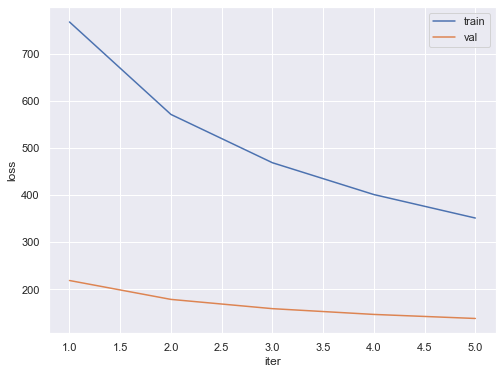

In [104]:
plt.figure(figsize=(8,6))
sns.set()
plt.xlabel('iter')
plt.ylabel('loss')
plt.plot(model.cnt_list, model.l_list, label='train')
plt.plot(model.cnt_list, model.l_val_list, label='val')
plt.legend()

In [105]:
y_pred = model.predict(X_val)
y_true = np.argmax(y_val, axis=1)

print(accuracy_score(y_true, y_pred))

0.9655833333333333


In [106]:
y_pred_tr = model.predict(X_train)
y_true_tr = np.argmax(y_train, axis=1)

print(accuracy_score(y_true_tr, y_pred_tr))

0.9794375
